# MLP Face Recognition

In [1]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import numpy as np
import os, cv2

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """helper function to plot a gallery of potraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [3]:
dir_name = "dataset/faces/"
y = [];x = [];target_names = []
person_id = 0;h = w = 300
n_samples = 0
class_names = []

for person_name in os.listdir(dir_name):
    #print(person_name)
    dir_path = dir_name+person_name+"/"
    class_names.append(person_name)
    for image_name in os.listdir(dir_path):
        """formulate image path"""
        image_path = dir_path+image_name
        """read the input image"""
        img = cv2.imread(image_path)
        """convert into grayscale"""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        """resize image to 300*300 dimension"""
        resized_image = cv2.resize(gray,(h,w))
        """convert matrix to vector"""
        v = resized_image.flatten()
        x.append(v)
        """increase number of samples"""
        n_samples = n_samples + 1
        """adding the categorical label"""
        y.append(person_id)
        """adding the person name"""
        target_names.append(person_name)
    person_id = person_id + 1

"""transform list to numpy array"""
y = np.array(y)
x = np.array(x)
target_names = np.array(target_names)
n_features = x.shape[1]
print(y.shape, x.shape, target_names.shape)
print(f"Number of samples:{n_samples}")

# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# """introspect the images arrays to find the shapes (for plotting)"""
# n_samples, h, w = lfw_people.images.shape
# print(n_samples, h, w)
# """for machine learning, using 2 data directly (relative pixel position info is ignored by this model)"""
# x = lfw_people.data
# n_features = x.shape[0]

# print(x.shape)
# """label to predict is the id of the person"""
# y = lfw_people.target
# print(y)
# if 0 in y:
#     print("yes")
# target_names = lfw_people.target_names
# print(target_names)
n_classes = target_names.shape[0]

print("Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_featues: {n_features}")
print(f"n_classes {n_classes}")

(450,) (450, 90000) (450,)
Number of samples:450
Total dataset size:
n_samples: 450
n_featues: 90000
n_classes 450


Extracting the top 150 eigenfaces from 337 faces


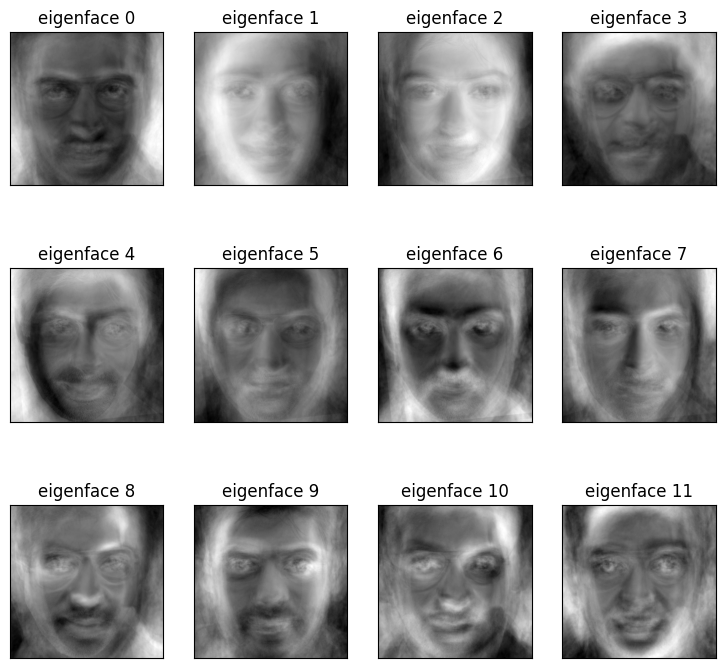

Projecting the input data on the eigenfaces orthonormal basis
(337, 150) (113, 150)
Project done...


In [4]:
"""split into a training set and a testing set"""
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

"""compute a PCA (eigenfaces) on the face dataset (treated as unlabled dataset): unsupervised feature extraction / dimensional reduction"""
n_components = 150

print(f"Extracting the top {n_components} eigenfaces from {x_train.shape[0]} faces")

"""applying PCA"""
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(x_train)

"""generating eigenfaces"""
eigenfaces = pca.components_.reshape((n_components, h, w))

"""plotting the gallery of the most significat eignefaces"""
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca.shape, x_test_pca.shape)

"""compute fisherfaces"""
lda = LinearDiscriminantAnalysis()
"""compute LDA of reduced data"""
lda.fit(x_train_pca, y_train)

x_train_lda = lda.transform(x_train_pca)
x_test_lda = lda.transform(x_test_pca)

print("Project done...")

In [5]:
"""training with multi layer perception"""
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10,10), max_iter=1000, verbose=True).fit(x_train_lda, y_train)
print("Model Weights:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 3.17188690
Iteration 2, loss = 3.12814680
Iteration 3, loss = 3.08406570
Iteration 4, loss = 3.04264082
Iteration 5, loss = 3.00229774
Iteration 6, loss = 2.96231577
Iteration 7, loss = 2.92375952
Iteration 8, loss = 2.88681750
Iteration 9, loss = 2.84998397
Iteration 10, loss = 2.81491178
Iteration 11, loss = 2.77967587
Iteration 12, loss = 2.74611115
Iteration 13, loss = 2.71411201
Iteration 14, loss = 2.68141716
Iteration 15, loss = 2.65000816
Iteration 16, loss = 2.61979850
Iteration 17, loss = 2.59014160
Iteration 18, loss = 2.56068910
Iteration 19, loss = 2.53179878
Iteration 20, loss = 2.50374311
Iteration 21, loss = 2.47671179
Iteration 22, loss = 2.45051605
Iteration 23, loss = 2.42409476
Iteration 24, loss = 2.39828477
Iteration 25, loss = 2.37308256
Iteration 26, loss = 2.34845190
Iteration 27, loss = 2.32362803
Iteration 28, loss = 2.30024468
Iteration 29, loss = 2.27642620
Iteration 30, loss = 2.25310248
Iteration 31, loss = 2.23000173
Iteration 32, los

Accuracy: 75.22123893805309


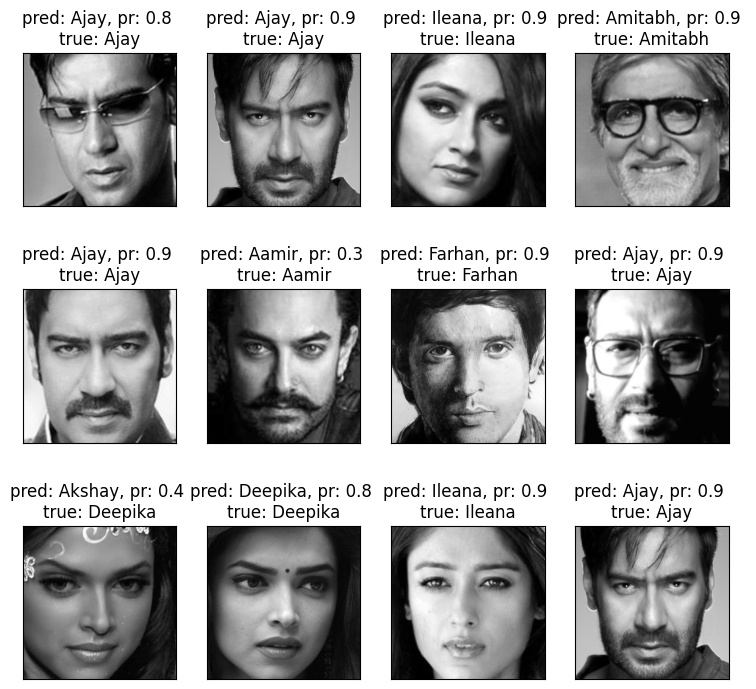

In [6]:
y_pred=[]; y_prob=[]
for test_face in x_test_lda:
    prob = clf.predict_proba([test_face])[0]
    # print(prob,np.max(prob))
    class_id = np.where(prob == np.max(prob))[0][0]
    """finding the label of the mathed face"""
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

"""transform the data"""
y_pred = np.array(y_pred)

prediction_titles = []
true_positive = 0
for i in range(y_pred.shape[0]):
    # print(y_test[i], y_pred[i])
    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]
    result = 'pred: %s, pr: %s \ntrue: %s' % (pred_name, str(y_prob[i])[0:3], true_name)
    prediction_titles.append(result)
    if true_name == pred_name:
        true_positive = true_positive+1

print("Accuracy:", true_positive*100/y_pred.shape[0])

"""plot results"""
plot_gallery(x_test, prediction_titles, h, w)
plt.show()